In [4]:
# Standard imports
import numpy as np
import pandas as pd

# For statistical modeling
import scipy.stats as stats

import random

# To acquire MYSQL Data
import acquire
from env import username, password, host
from cluster_wrangle import scale_data, train_validate_test, wrangle_zillow, remove_outliers, rfe, rmse, pf
from cluster_wrangle import lasso_lars, glm, pf_test, value_viz, pred_act, no_error, test, vis, graph, split, n_error
import cluster_eval

# For data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# To avoid deprecation and other warnings
import warnings
warnings.filterwarnings('ignore')

# For modeling
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LogisticRegression, LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector

### 1. Acquire data from the customers table in the mall_customers database.
### 2. Summarize the data (include distributions and descriptive statistics).
### 3. Detect outliers using IQR.
### 4. Split data into train, validate, and test.
### 5. Encode categorical columns using a one hot encoder (pd.get_dummies).
### 6. Handles missing values.
### 7. Scaling

In [6]:
from env import username, password, host

In [8]:
def get_db_url(username, hostname, password, database):
    url = f'mysql+pymysql://{username}:{password}@{hostname}/{database}'
    return url

In [9]:
#def get_connection(db, username=env.username, host=env.host, password=env.password):
#    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

def get_mallcustomer_data():
    '''
    Reads in all fields from the customers table in the mall_customers schema from data.codeup.com
    
    parameters: None
    
    returns: a single Pandas DataFrame with the index set to the primary customer_id field
    '''
    df = pd.read_sql('SELECT * FROM customers;', get_connection('mall_customers'))
    return df.set_index('customer_id')

In [22]:
def summarize(df):
    print('df Describe:')
    print(df.describe())
    print('df Info:')
    print(df.info())
    print('-------')
    for col in df:
        print(df[col].value_counts(bins=15, sort=False))

### 1. Acquire data from the customers table in the mall_customers database.

In [11]:
mall = pd.read_csv('mall_data.csv')

In [27]:
mall = mall.set_index('customer_id')

In [28]:
mall

,gender,age,annual_income,spending_score
customer_id,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40
...,...,...,...,...
196,Female,35,120,79
197,Female,45,126,28
198,Male,32,126,74


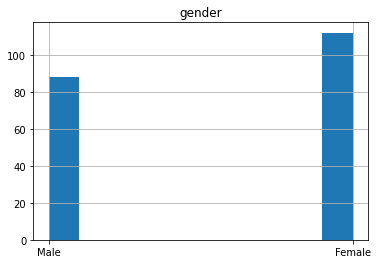

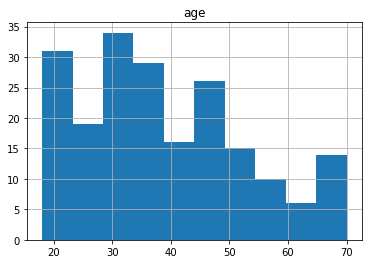

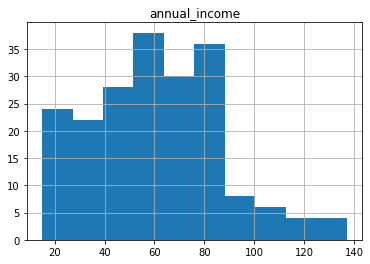

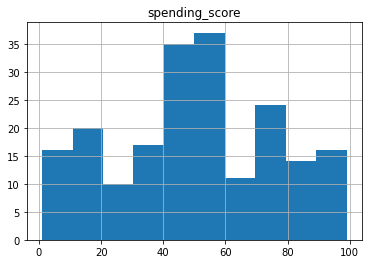

In [29]:
for col in mall.columns:
    mall[col].hist()
    plt.title(col)
    plt.show()

### 2. Summarize the data (include distributions and descriptive statistics).

In [30]:
summarize(mall)

df Describe:
              age  annual_income  spending_score
count  200.000000     200.000000      200.000000
mean    38.850000      60.560000       50.200000
std     13.969007      26.264721       25.823522
min     18.000000      15.000000        1.000000
25%     28.750000      41.500000       34.750000
50%     36.000000      61.500000       50.000000
75%     49.000000      78.000000       73.000000
max     70.000000     137.000000       99.000000
df Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          200 non-null    object
 1   age             200 non-null    int64 
 2   annual_income   200 non-null    int64 
 3   spending_score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB
None
-------


TypeError: bins argument only works with numeric data.

### 3. Detect outliers using IQR.

<function matplotlib.pyplot.show(close=None, block=None)>

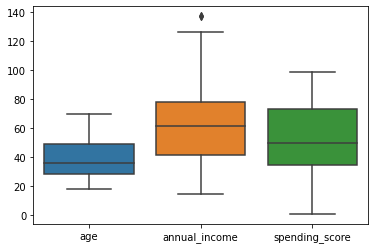

In [44]:
sns.boxplot(data=mall)
plt.show

In [48]:
mall[mall.annual_income > 120]

,gender,age,annual_income,spending_score
customer_id,,,,
197,Female,45,126,28
198,Male,32,126,74
199,Male,32,137,18
200,Male,30,137,83


In [56]:
mall['annual_income'].max()

137

In [68]:
mall.drop(index=[199,200], inplace=True)

<function matplotlib.pyplot.show(close=None, block=None)>

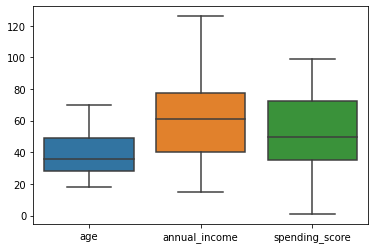

In [69]:
sns.boxplot(data=mall)
plt.show

### 4. Split data into train, validate, and test.

In [86]:
X_train, y_train, X_validate, y_validate, X_test, y_test = train_validate_test(mall, 'spending_score')

In [87]:
X_train

,gender,age,annual_income
customer_id,,,
23,Female,46,25
16,Male,22,20
30,Female,23,29
120,Female,50,67
187,Female,54,101
...,...,...,...
154,Female,38,78
178,Male,27,88
162,Female,29,79


### 5. Encode categorical columns using a one hot encoder (pd.get_dummies).

In [88]:
X_train = pd.get_dummies(X_train, columns=['gender'], drop_first=True)

### 6. Handles missing values.

In [90]:
X_train.isnull().sum()

age              0
annual_income    0
gender_Male      0
dtype: int64

### 7. Scaling

In [74]:
def scale_data(train, 
               validate, 
               test, 
               columns=[], return_scaler=False):
    '''
    Scales train, validate, test and returns scaled versions of each 
    If return_scalar is True, the scaler object will be returned as well
    '''
    # make copies
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    # Make the scaler
    scaler = MinMaxScaler()
    # Fit it
    scaler.fit(train[columns])
    # Apply the scaler:
    train_scaled[columns] = pd.DataFrame(scaler.transform(train[columns]),
                                                  columns=train[columns].columns.values).set_index([train.index.values])
                                                  
    validate_scaled[columns] = pd.DataFrame(scaler.transform(validate[columns]),
                                                  columns=validate[columns].columns.values).set_index([validate.index.values])
    
    test_scaled[columns] = pd.DataFrame(scaler.transform(test[columns]),
                                                 columns=test[columns].columns.values).set_index([test.index.values])
    
    if return_scaler:
        return scaler, train_scaled, validate_scaled, test_scaled
    else:
        return train_scaled, validate_scaled, test_scaled

In [91]:
X_train.columns

Index(['age', 'annual_income', 'gender_Male'], dtype='object')

In [93]:
X_train_scaled, X_validate_scaled, X_test_scaled = scale_data(X_train, X_validate, X_test, columns = ['age', 'annual_income'])

In [94]:
X_train_scaled

,age,annual_income,gender_Male
customer_id,,,
23,0.538462,0.095238,0
16,0.076923,0.047619,1
30,0.096154,0.133333,0
120,0.615385,0.495238,0
187,0.692308,0.819048,0
...,...,...,...
154,0.384615,0.600000,0
178,0.173077,0.695238,1
162,0.211538,0.609524,0


In [96]:
rmse(y_train, y_validate, 'spending_score')

R̲M̲S̲E

Using Mean:
Train(In-Sample):        25
Validate(Out-of-Sample): 26

Using Median:
Train(In-Sample):        25
Validate(Out-of-Sample): 26


In [100]:
X_validate_scaled = pd.get_dummies(X_validate_scaled, columns=['gender'], drop_first=True)

In [102]:
X_validate_scaled.head(3)

,age,annual_income,gender_Male
customer_id,,,
34,0.000000,0.171429,1
49,0.211538,0.238095,0
117,0.865385,0.476190,0


In [103]:
X_test_scaled = pd.get_dummies(X_test_scaled, columns=['gender'], drop_first=True)

In [106]:
def pf(X_train, y_train, X_validate, y_validate, X_test, y_test, target, n):
# make the polynomial features to get a new set of features
    n=n
    pf = PolynomialFeatures(degree=n)

# fit and transform X_train_scaled
    X_train_degree = pf.fit_transform(X_train)

# transform X_validate & X_test
    X_validate_degree = pf.transform(X_validate)
    X_test_degree = pf.transform(X_test)

## **LinearRegression**
# create the model object
    lm = LinearRegression(normalize=True)

# fit 
    lm.fit(X_train_degree, y_train[target])

# predict and use train
    y_train['pred_lm'] = lm.predict(X_train_degree)

# evaluate: rmse
    rmse_train = mean_squared_error(y_train[target], y_train.pred_lm) ** (1/2)

# predict validate
    y_validate['pred_lm'] = lm.predict(X_validate_degree)

# evaluate: rmse
    rmse_validate = mean_squared_error(y_validate[target], y_validate.pred_lm) ** (1/2)
    
# Predict Test
    y_test['pred_lm'] = lm.predict(X_test_degree)
    lm_rmse_test = mean_squared_error(y_test[target], y_test.pred_lm) ** (1/2)

    print('\033[1m' + '\u0332'.join('OLS using LinearRegression')+ '\033[0m')
    print()
    print(f'RMSE for Training/In-Sample:        {round(rmse_train)}')
    print(f'RMSE for Validation/Out-of-Sample:  {round(rmse_validate)}')
    print(f'R^2 Validate:                       {round(explained_variance_score(y_validate[target], y_validate.pred_lm), 3)}')

In [107]:
pf(X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test, 'spending_score', 1)

O̲L̲S̲ ̲u̲s̲i̲n̲g̲ ̲L̲i̲n̲e̲a̲r̲R̲e̲g̲r̲e̲s̲s̲i̲o̲n

RMSE for Training/In-Sample:        23
RMSE for Validation/Out-of-Sample:  24
R^2 Validate:                       0.141


-----

In [5]:
summarize(zillow)

df Describe:
         Unnamed: 0  propertylandusetypeid      parcelid            id  \
count  77580.000000           77580.000000  7.758000e+04  7.758000e+04   
mean   38789.500000             261.824465  1.300828e+07  1.495404e+06   
std    22395.561279               5.141564  3.519376e+06  8.609700e+05   
min        0.000000              31.000000  1.071186e+07  3.490000e+02   
25%    19394.750000             261.000000  1.153820e+07  7.521430e+05   
50%    38789.500000             261.000000  1.253056e+07  1.498256e+06   
75%    58184.250000             266.000000  1.421135e+07  2.240950e+06   
max    77579.000000             275.000000  1.676893e+08  2.982274e+06   

       airconditioningtypeid  architecturalstyletypeid  basementsqft  \
count           25007.000000                207.000000     50.000000   
mean                1.812013                  7.386473    679.720000   
std                 2.965768                  2.728030    689.703546   
min                 1.000000    

(562.957, 2934.133]       2342
(2934.133, 5270.267]       651
(5270.267, 7606.4]          29
(7606.4, 9942.533]           2
(9942.533, 12278.667]        1
(12278.667, 14614.8]         0
(14614.8, 16950.933]         0
(16950.933, 19287.067]       1
(19287.067, 21623.2]         0
(21623.2, 23959.333]         0
(23959.333, 26295.467]       0
(26295.467, 28631.6]         0
(28631.6, 30967.733]         0
(30967.733, 33303.867]       0
(33303.867, 35640.0]         1
Name: finishedsquarefeet15, dtype: int64
(31.576, 872.2]       1172
(872.2, 1700.4]       3603
(1700.4, 2528.6]       929
(2528.6, 3356.8]       204
(3356.8, 4185.0]        70
(4185.0, 5013.2]        31
(5013.2, 5841.4]        12
(5841.4, 6669.6]         9
(6669.6, 7497.8]         3
(7497.8, 8326.0]         2
(8326.0, 9154.2]         1
(9154.2, 9982.4]         0
(9982.4, 10810.6]        0
(10810.6, 11638.8]       0
(11638.8, 12467.0]       1
Name: finishedsquarefeet50, dtype: int64
(374.781, 727.867]      34
(727.867, 1075.733]  

TypeError: bins argument only works with numeric data.

Univariate visualization

In [14]:
mall = pd.read_csv('mall_data.csv')

In [15]:
mall.isnull().sum()

customer_id       0
gender            0
age               0
annual_income     0
spending_score    0
dtype: int64

In [16]:
wrangle.scale_data(mall)

NameError: name 'wrangle' is not defined

In [17]:
mall

,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [18]:
evaluate.best_features(mall, mall[['spending_score']], 2)

NameError: name 'col' is not defined

In [19]:
# make a function that gets the mean/median for every column and the mean/median of those columns for each value_counts? (or just some of them)
def a():
    print('a')

In [20]:
evaluate.nulls_by_col(mall)

0.0


,num_rows_missing,percent_rows_missing
customer_id,0,0.0
gender,0,0.0
age,0,0.0
annual_income,0,0.0
spending_score,0,0.0


In [21]:
mall.isnull().sum().sum()

0

In [22]:
mall.shape[1]*mall.shape[0]

1000

In [23]:
zillow = pd.read_csv('zillow_2017_w_transactiondate.csv')

In [24]:
zillow.head()

,Unnamed: 0,propertylandusetypeid,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,...,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,logerror,transactiondate,propertylandusedesc
0,0,261.0,14297519,1727539,NaN,NaN,NaN,3.5,4.0,NaN,...,2016.0,537569.0,11013.72,NaN,NaN,6.059063e+13,0,0.025595,2017-01-01,Single Family Residential
1,1,261.0,17052889,1387261,NaN,NaN,NaN,1.0,2.0,NaN,...,2016.0,376000.0,5672.48,NaN,NaN,6.111001e+13,1,0.055619,2017-01-01,Single Family Residential
2,2,261.0,14186244,11677,NaN,NaN,NaN,2.0,3.0,NaN,...,2016.0,479489.0,6488.30,NaN,NaN,6.059022e+13,2,0.005383,2017-01-01,Single Family Residential
3,3,261.0,12177905,2288172,NaN,NaN,NaN,3.0,4.0,NaN,...,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13,3,-0.103410,2017-01-01,Single Family Residential
4,4,266.0,10887214,1970746,1.0,NaN,NaN,3.0,3.0,NaN,...,2016.0,45726.0,1533.89,NaN,NaN,6.037124e+13,4,0.006940,2017-01-01,Condominium


In [25]:
evaluate.nulls_by_col(zillow)

1791.5941221964424


,num_rows_missing,percent_rows_missing
Unnamed: 0,0,0.000000
propertylandusetypeid,0,0.000000
parcelid,0,0.000000
id,0,0.000000
airconditioningtypeid,52573,67.766177
...,...,...
censustractandblock,247,0.318381
id.1,0,0.000000
logerror,0,0.000000
transactiondate,0,0.000000


In [29]:
import numpy as np
from sklearn.datasets import load_iris
import pandas as pd
 
data = load_iris()
df = pd.DataFrame(data.data,
                  columns = data.feature_names)
 
# The scope of these changes made to
# pandas settings are local to with statement.
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(df)

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                  5.1               3.5                1.4               0.2
1                  4.9               3.0                1.4               0.2
2                  4.7               3.2                1.3               0.2
3                  4.6               3.1                1.5               0.2
4                  5.0               3.6                1.4               0.2
5                  5.4               3.9                1.7               0.4
6                  4.6               3.4                1.4               0.3
7                  5.0               3.4                1.5               0.2
8                  4.4               2.9                1.4               0.2
9                  4.9               3.1                1.5               0.1
10                 5.4               3.7                1.5               0.2
11                 4.8               3.4                1.6     

### Explore!
Ask your question

Vizualize it

Perform a stats test, if needed

Write your takeaway